# Content-Based Recommender System

# Outline
- [ 1 - Packages ](#1)
- [ 2 - Downloading the Dataset ](#2)
- [ 3 - Analysis of the Data](#3)
- [ 4 - Preparing the Training Data](#4)
- [ 5 - Content-Based Filtering with a Neural Network](#5)



<a name="1"></a>
## 1 - Packages 

In [33]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import requests
import re
from zipfile import ZipFile
pd.set_option("display.precision", 1)

<a name="2"></a>
## 2 - Downloading the Dataset 
The data set is derived from the [MovieLens "ml-latest-small"](https://grouplens.org/datasets/movielens/latest/) dataset.   
[F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>]

The dataset has 9742 movies rated by 610 users.

The dataset comes as a .zip file. Let's first download the dataset using the request module.

In [34]:
# specifying the url of the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

# downloaing the file
r = requests.get(url, allow_redirects=True)

#opening the file and saving the contents
open('ml-latest-small.zip', 'wb').write(r.content)

978202

In [35]:
# specifying the zip file name
file_name = "ml-latest-small.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zipp:
    # printing all the contents of the zip file
    zipp.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zipp.extractall()
    print('Done!')

File Name                                             Modified             Size
ml-latest-small/                               2018-09-26 15:50:12            0
ml-latest-small/links.csv                      2018-09-26 15:50:10       197979
ml-latest-small/tags.csv                       2018-09-26 15:49:40       118660
ml-latest-small/ratings.csv                    2018-09-26 15:49:38      2483723
ml-latest-small/README.txt                     2018-09-26 15:50:12         8342
ml-latest-small/movies.csv                     2018-09-26 15:49:56       494431
Extracting all the files now...
Done!


<a name="3"></a>
## 3 - Analysis of the Data

Let's first have a look at the data. There are 4 different tables in the main table:<br />
1.links<br />
2.tags<br />
3.ratings<br />
4.movies<br />

Let's start with the links table first:

In [36]:
links_df = pd.read_csv('ml-latest-small/links.csv')
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [37]:
links_df.head(5)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


It can be seen that the links table contains infomration about the ID of the film in IMDB and The Movie Database. 

In [38]:
tags_df = pd.read_csv('ml-latest-small/tags.csv')
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [39]:
tags_df.head(5)

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


As can be seen, each row in the tags table contains a tag about one movie by one user. The tag is either one word or an expression. 

In [40]:
movies_df = pd.read_csv('ml-latest-small/movies.csv')
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [41]:
movies_df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Overall there are 9742 movies in the dataset.

In [42]:
ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [43]:
ratings_df.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [44]:
pd.unique(ratings_df['movieId']).shape

(9724,)

In [45]:
pd.unique(ratings_df['userId']).shape

(610,)

We saw that there are 9742 movies in the dataset; however, the ratings table only has 9724 different movies, so not all of the movies are rated but all of the users have rated at least 1 movie. 

<a name="4"></a>
## 4 - Preparing the Training Data

For this project, we will be using the ratings table and the mocies to create our training data. Each row in the ratings table contains the rating of one mivie by one user. The lines within this file are ordered first by userId, then, within user, by movieId. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970. In total, there are 100836 ratings in the table.

First, let's create a dataframe from the movies that have been rated by at least a user. 

In [46]:
#specifying the rated_movies_df dataframe as the movies that have at least one rating
rated_movies_df = movies_df[movies_df['movieId'].isin(list(pd.unique(ratings_df['movieId'])))]

#calculating the average rating for each movie
rated_movies_df['rating'] = list(ratings_df.groupby('movieId',as_index=False).mean()['rating'])

#resetting the index
rated_movies_df.reset_index(inplace=True,drop=True)

#displaying the rated_movies_df dataframe
rated_movies_df

<ipython-input-46-c1fbf47b431d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated_movies_df['rating'] = list(ratings_df.groupby('movieId',as_index=False).mean()['rating'])


,movieId,title,genres,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.9
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.4
2,3,Grumpier Old Men (1995),Comedy|Romance,3.3
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.4
4,5,Father of the Bride Part II (1995),Comedy,3.1
...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,4.0
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,3.5
9721,193585,Flint (2017),Drama,3.5
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,3.5


For content-based filtering, we need to have feature vectors for both users and the movies. We will extract these features from the movies and ratings tables. 
For each movie, the features could be the genre of the movie, the average rating of the movie calculated from the ratings of all users who have rated that movie. and the year that the movie was filmed. 
For each user, the features could be the average rating that the user has given to each genre of movies. 

For starters,let's find all of the genres in our dataset from the rated_movies_df dataframe.

In [47]:
# specifying the genres as a set to eliminate duplicate values
genres_set = set()

#extracting all of the mentioned genres in the dataset
for i in range (0,rated_movies_df.shape[0]):

    genres_set.update((rated_movies_df.iloc[i,2]).split('|'))
    
#converting the set to list and displaying it   
genres_list  = list(genres_set)
genres_list

['Drama',
 '(no genres listed)',
 'Musical',
 'Documentary',
 'Film-Noir',
 'Fantasy',
 'Animation',
 'Romance',
 'Adventure',
 'Horror',
 'Action',
 'Comedy',
 'Children',
 'IMAX',
 'Crime',
 'Sci-Fi',
 'War',
 'Mystery',
 'Western',
 'Thriller']

It looks like we have 19 different genres for our movies and some movies do not have any genres.

In order to create the movies features dataset, we need to specify which genres each movie is associated with and to be able to feed the data to our model we need to convert the categorial variables to one hot variables. But since the genres column in rated_movies_df contains several genres, we need to come up with our own encoder. 

In [76]:
#creating the column headers for the movie_features_df
columns = ['[movieId]','Year','Average_Rating']
columns.extend(genres_list)

movie_features_dict = {i : [] for i in columns}


for i in range (0,rated_movies_df.shape[0]):
        
        # extracting the id of the movie
        movie_features_dict['[movieId]'].append(rated_movies_df.iloc[i,0])
        
        # extracting the average rating of the movie
        movie_features_dict['Average_Rating'].append(rated_movies_df.iloc[i,3])
        
        #extracting the genre of the movie, set thespecific genre to 1 if mentioned and 0 if not mentioned
        genres = (rated_movies_df.iloc[i,2]).split('|')

        for genre in genres_list:
            if genre in genres:
                movie_features_dict[genre].append(1)
            else:
                movie_features_dict[genre].append(0)
        
        # finding the year at which movie was filmed
        match = re.search(r'\((\d\d\d\d)\)', str(rated_movies_df.iloc[i,1]))
        
        if match == None :
            movie_features_dict['Year'].append(0)
        
        else:        
            movie_features_dict['Year'].append(int(match.group(1)))   
            
movie_features_df = pd.DataFrame(movie_features_dict)
movie_features_df.loc[movie_features_df.loc[movie_features_df['Year']>2000]['IMAX'] == 1, :]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

movie_features_df contains information about the movie ID, the year the movie was filmed, the average_rating of the movie and the genre of the movie. We should not use the movies that do not have any listed genres, and the ones for which a year is not reported, so we drop these movies and we drop the (no genres listed) column as well.  

In [49]:
movie_features_df.drop(movie_features_df[movie_features_df['(no genres listed)'] == 1].index,inplace = True)
movie_features_df.drop(movie_features_df[movie_features_df['Year'] == 0].index,inplace = True)
movie_features_df.drop(['(no genres listed)'],axis=1,inplace= True)

In [50]:
ratings_df_mod = ratings_df.loc[ratings_df['movieId'].isin(movie_features_df['[movieId]']),:]
ratings_df_mod.reset_index(inplace=True,drop=True)
ratings_df_mod

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100776,610,166534,4.0,1493848402
100777,610,168248,5.0,1493850091
100778,610,168250,5.0,1494273047
100779,610,168252,5.0,1493846352


The final training dataset for the movies should have information about the movie and user pairs in the ratings dataset.

In [51]:
num_of_users = pd.unique(ratings_df_mod['userId']).shape[0]

columns.remove('(no genres listed)')

movie_ratings_features_array = np.zeros((1,len(genres_list)+2))

for i in range (1,num_of_users+1):
    
    movie_ratings_features_array = np.append(movie_ratings_features_array,(movie_features_df.loc[movie_features_df['[movieId]'].isin(ratings_df_mod.loc[ratings_df_mod['userId'].isin([i]),'movieId']),:]).to_numpy(),axis=0)
movie_ratings_features_array = movie_ratings_features_array[1:,:]
movie_ratings_features_df = pd.DataFrame(movie_ratings_features_array,columns=columns)   

movie_ratings_features_df

,[movieId],Year,Average_Rating,Drama,Musical,Documentary,Film-Noir,Fantasy,Animation,Romance,...,Action,Comedy,Children,IMAX,Crime,Sci-Fi,War,Mystery,Western,Thriller
0,1.0,1995.0,3.9,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,1995.0,3.3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6.0,1995.0,3.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,47.0,1995.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,50.0,1995.0,4.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100776,166534.0,2017.0,3.3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
100777,168248.0,2017.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
100778,168250.0,2017.0,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100779,168252.0,2017.0,4.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [52]:
num_of_users = pd.unique(ratings_df_mod['userId']).shape[0]

user_ratings_features_array =  np.zeros((1,len(genres_list)+2))



for i in range (1,num_of_users+1):

            genres_array = (movie_features_df.loc[movie_features_df['[movieId]'].isin(ratings_df_mod.loc[ratings_df_mod['userId'].isin([i]),'movieId']),'Drama':]).to_numpy()

            
            user_movie_ratings_array = (ratings_df_mod.loc[ratings_df_mod['userId'].isin([i]),'rating']).to_numpy()

            
            user_movie_ratings_array_broadcasted = np.tile(user_movie_ratings_array, (len(genres_list)-1,1))
            
            
            user_rating = np.sum(np.multiply(genres_array,user_movie_ratings_array_broadcasted.transpose()),axis=0)/np.sum(genres_array,axis=0)
            
            user_rating[np.isnan(user_rating)] = 0
            
            user_rating_row = np.append([i,ratings_df_mod.loc[ratings_df_mod['userId'].isin([i]),'rating'].count(),ratings_df_mod.loc[ratings_df_mod['userId'].isin([i]),'rating'].mean()],user_rating,axis=0)
            
            user_rating_row = np.tile(user_rating_row, (ratings_df_mod.loc[ratings_df_mod['userId'].isin([i]),'rating'].count(),1))
            
            user_ratings_features_array = np.append(user_ratings_features_array,user_rating_row,axis=0)

user_ratings_features_array = user_ratings_features_array[1:,:]            
columns_user = ['[userId]','[Rating_Count]','Average_Rating']
columns_user.extend(genres_list)
columns_user.remove('(no genres listed)')   
                    
user_ratings_features_df = pd.DataFrame(user_ratings_features_array,columns = columns_user)
user_ratings_features_df

<ipython-input-52-1ac5d6de9128>:18: RuntimeWarning: invalid value encountered in divide
  user_rating = np.sum(np.multiply(genres_array,user_movie_ratings_array_broadcasted.transpose()),axis=0)/np.sum(genres_array,axis=0)


,[userId],[Rating_Count],Average_Rating,Drama,Musical,Documentary,Film-Noir,Fantasy,Animation,Romance,...,Action,Comedy,Children,IMAX,Crime,Sci-Fi,War,Mystery,Western,Thriller
0,1.0,232.0,4.4,4.5,4.7,0.0,5.0,4.3,4.7,4.3,...,4.3,4.3,4.5,0.0,4.4,4.2,4.5,4.2,4.3,4.1
1,1.0,232.0,4.4,4.5,4.7,0.0,5.0,4.3,4.7,4.3,...,4.3,4.3,4.5,0.0,4.4,4.2,4.5,4.2,4.3,4.1
2,1.0,232.0,4.4,4.5,4.7,0.0,5.0,4.3,4.7,4.3,...,4.3,4.3,4.5,0.0,4.4,4.2,4.5,4.2,4.3,4.1
3,1.0,232.0,4.4,4.5,4.7,0.0,5.0,4.3,4.7,4.3,...,4.3,4.3,4.5,0.0,4.4,4.2,4.5,4.2,4.3,4.1
4,1.0,232.0,4.4,4.5,4.7,0.0,5.0,4.3,4.7,4.3,...,4.3,4.3,4.5,0.0,4.4,4.2,4.5,4.2,4.3,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100776,610.0,1302.0,3.7,3.9,3.9,4.2,4.3,3.6,3.9,3.7,...,3.6,3.7,3.7,3.6,3.8,3.7,3.8,3.8,3.7,3.6
100777,610.0,1302.0,3.7,3.9,3.9,4.2,4.3,3.6,3.9,3.7,...,3.6,3.7,3.7,3.6,3.8,3.7,3.8,3.8,3.7,3.6
100778,610.0,1302.0,3.7,3.9,3.9,4.2,4.3,3.6,3.9,3.7,...,3.6,3.7,3.7,3.6,3.8,3.7,3.8,3.8,3.7,3.6
100779,610.0,1302.0,3.7,3.9,3.9,4.2,4.3,3.6,3.9,3.7,...,3.6,3.7,3.7,3.6,3.8,3.7,3.8,3.8,3.7,3.6


In [53]:
Y = ratings_df_mod['rating'].to_numpy()
Y.shape

(100781,)

<a name="5"></a>
## 5 - Content-Based Filtering with a Neural Network

As dscussed earlier, a per genre average rating is computed per user. Additionally, a user id, rating count and rating average are available but not included in the training or prediction content. They are carried with the data set because they are useful in interpreting data.

The training set consists of all the ratings made by the users in the data set. The training set is split into two arrays with the same number of entries, a user array and a movie/item array.  

Below, let's load and display some of the data.

In [54]:
num_user_features = user_ratings_features_array.shape[1] - 3  # remove userid, rating count and ave rating during training
num_item_features = movie_ratings_features_array.shape[1] - 1  # remove movie id at train time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
print(f"Number of training vectors: {len(movie_ratings_features_array)}")

Number of training vectors: 100781


We'll scale the target ratings using a Min Max Scaler which scales the target to be between -1 and 1.

In [55]:
# scale training data
movie_ratings_features_array_train_unscaled = movie_ratings_features_array
user_ratings_features_array_train_unscaled = user_ratings_features_array
y_train_unscaled    = Y

scalerItem = StandardScaler()
scalerItem.fit(movie_ratings_features_array)
movie_ratings_features_array = scalerItem.transform(movie_ratings_features_array)

scalerUser = StandardScaler()
scalerUser.fit(user_ratings_features_array)
user_ratings_features_array = scalerUser.transform(user_ratings_features_array)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(Y.reshape(-1, 1))
Y = scalerTarget.transform(Y.reshape(-1, 1))


print(np.allclose(movie_ratings_features_array_train_unscaled, scalerItem.inverse_transform(movie_ratings_features_array)))
print(np.allclose(user_ratings_features_array_train_unscaled, scalerUser.inverse_transform(user_ratings_features_array)))

True
True


To allow us to evaluate the results, we will split the data into training and test sets.

In [56]:
movie_ratings_features_array_train, movie_ratings_features_array_test = train_test_split(movie_ratings_features_array, train_size=0.80, shuffle=True)
user_ratings_features_array_train, user_ratings_features_array_test = train_test_split(user_ratings_features_array, train_size=0.80, shuffle=True)
Y_train, Y_test       = train_test_split(Y,    train_size=0.80, shuffle=True)
print(f"movie/item training data shape: {movie_ratings_features_array_train.shape}")
print(f"movie/item test data shape: {movie_ratings_features_array_test.shape}")

movie/item training data shape: (80624, 22)
movie/item test data shape: (20157, 22)


The scaled, shuffled data now has a mean of zero.

Now, let's construct a neural network. It will have two networks that are combined by a dot product. For simplification the two networks are identical.

In [68]:
num_outputs = 8

user_NN = tf.keras.models.Sequential([
     
  tf.keras.layers.Dense(units = 32 , activation = 'relu'),
  tf.keras.layers.Dense(units = 16 , activation = 'relu'), 
  tf.keras.layers.Dense(units = num_outputs , activation = 'linear'), 

])

item_NN = tf.keras.models.Sequential([
   
  tf.keras.layers.Dense(units = 64 , activation = 'relu'),
  tf.keras.layers.Dense(units = 32 , activation = 'relu'), 
  tf.keras.layers.Dense(units = num_outputs , activation = 'linear'),   

])

# create the user input and point to the base network
input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

# compute the dot product of the two vectors vu and vm
output = tf.keras.layers.Dot(axes=1)([vu, vm])

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 21)]         0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 8)            1304        ['input_7[0][0]']                
                                                                                                  
 sequential_7 (Sequential)      (None, 8)            3752        ['input_8[0][0]']                
                                                                                            

In [72]:
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=100)
model.compile(optimizer=opt,
              loss=cost_fn)

In [73]:
history = model.fit([user_ratings_features_array_train[:, u_s:], movie_ratings_features_array_train[:, i_s:]], Y_train, epochs=30,validation_data=([user_ratings_features_array_test[:, u_s:], movie_ratings_features_array_test[:, i_s:]], Y_test))

Epoch 1/30
2520/2520 [==============================] - 4s 1ms/step - loss: 0.2159 - val_loss: 0.2183
Epoch 2/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2154 - val_loss: 0.2146
Epoch 3/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2152 - val_loss: 0.2145
Epoch 4/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2152 - val_loss: 0.2146
Epoch 5/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2151 - val_loss: 0.2149
Epoch 6/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2150 - val_loss: 0.2146
Epoch 7/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2149 - val_loss: 0.2154
Epoch 8/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2149 - val_loss: 0.2146
Epoch 9/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.2148 - val_loss: 0.2147
Epoch 10/30
2520/2520 [==============================] - 3s 1ms/step - loss: 0.214

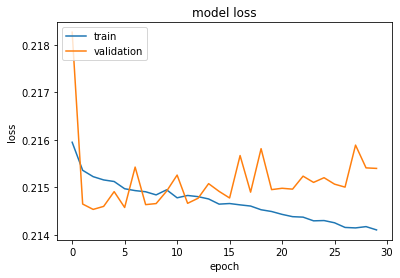

In [74]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

It is comparable to the training loss indicating the model has not substantially overfit the training data.